In [1]:
#### What happens when ONLY mode mismatch the Sqz into the IFO?

In [2]:
%matplotlib inline
import pykat
import pylab as pl
import numpy as np

### My functions
from kat_commands import *
from cav_commands import *
from load_kat_data import *
from MMT import modematch

import get_WS
import trace_mode

                                              ..-
    PyKat 1.0.17          _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat



In [3]:
katfile = "aLIGO_IFO_AWC_tuning_DCoff_maxtem4_modified.kat"
maxtem = 2

In [4]:
#load the original kat file (ie Perfect Modematching) as a reference
basekat = pykat.finesse.kat() 
basekat.loadKatFile(katfile)
basekat.parseCommands(darm_commands)
basekat.parseCommands(add_squeezing)
basekat.parseCommands(cav_commands_FC_first)
basekat.parseCommands("maxtem "+str(maxtem))
basekat.parseCommands("""
bp q_sqz_x x q nsqz
bp q_sqz_y y q nsqz
""")
basekat.undumpNodes() #undump the vacuum nodes
kat=basekat.deepcopy() #copy kat code
kat.verbose = False

out_perfect_mm = kat.run()

In [5]:
q_sqz_x = out_perfect_mm["q_sqz_x"][0]
q_sqz_y = out_perfect_mm["q_sqz_y"][0]

q_sqz_x_new = pykat.BeamParam(q=q_sqz_x + 3.5)
q_sqz_y_new = pykat.BeamParam(q=q_sqz_y + 3.5)

### Modify the q of the sqz to get 95% modematching to the original
q_sqz_in = "gauss cavSQZ sqz nsqz " +  str(q_sqz_x_new.w0) + " " + str(-q_sqz_x_new.z) +\
" " + str(q_sqz_y_new.w0) + " " + str(-q_sqz_y_new.z)

In [6]:
pykat.BeamParam.overlap(q_sqz_x_new,q_sqz_x)

0.9543281957213946

In [7]:
#run with new sqz q
basekat0 = pykat.finesse.kat() 
basekat0.loadKatFile(katfile)
basekat0.parseCommands(darm_commands)
basekat0.parseCommands(add_squeezing)
basekat0.parseCommands(cav_commands_FC_first)
basekat0.parseCommands(q_sqz_in)
basekat0.parseCommands("maxtem "+str(maxtem))
basekat0.parseCommands("""
bp q_sqz_x x q nsqz
bp q_sqz_y y q nsqz
""")
basekat0.undumpNodes() #undump the vacuum nodes
kat0=basekat0.deepcopy() #copy kat code
kat0.verbose = False

out_mismatch_sqz = kat0.run()

In [8]:
pykat.BeamParam.overlap(-np.conjugate(out_mismatch_sqz['q_sqz_x'][0]),out_perfect_mm['q_sqz_x'][0])

0.95432819572157845

In [9]:
##### Testing to trace the modes
#### Turn off all the cav commands except SRCY to extract the eigenmode at the BS
[srcx,srcy] = trace_mode.from_cav_to_BS(kat0,'cavSRY')

#### Turn off all the cav commands except XARM to extract the eigenmode at the BS
[ARMx,ARMy] = trace_mode.from_cav_to_BS(kat0,'cavXARM')

#### Turn off all the cav commands except OMC to extract the eigenmode at the BS
[OMCx,OMCy] = trace_mode.from_cav_to_BS(kat0,'cavOMC')

#### Turn off all the cav commands except FC to extract the eigenmode at the BS
[FCx,FCy] = trace_mode.from_cav_to_BS(kat0,'cavFC')

In [10]:
#### Get the sqz mode at the beamsplitter
for cav in kat0.getAll(pykat.commands.cavity):
        cav.enabled = False

out_get = kat0.run(getTraceData = True)
q_sqz_BS_x = out_get[1][0]['nPRBS'][0]._BeamParam__q
q_sqz_BS_y = out_get[1][0]['nPRBS'][1]._BeamParam__q

In [11]:
q_sqz_BS_x

(1322.35544041821+152.763107776408j)

In [12]:
pykat.BeamParam.overlap(FCx,q_sqz_BS_x)

1.0

/home/thomasvo/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


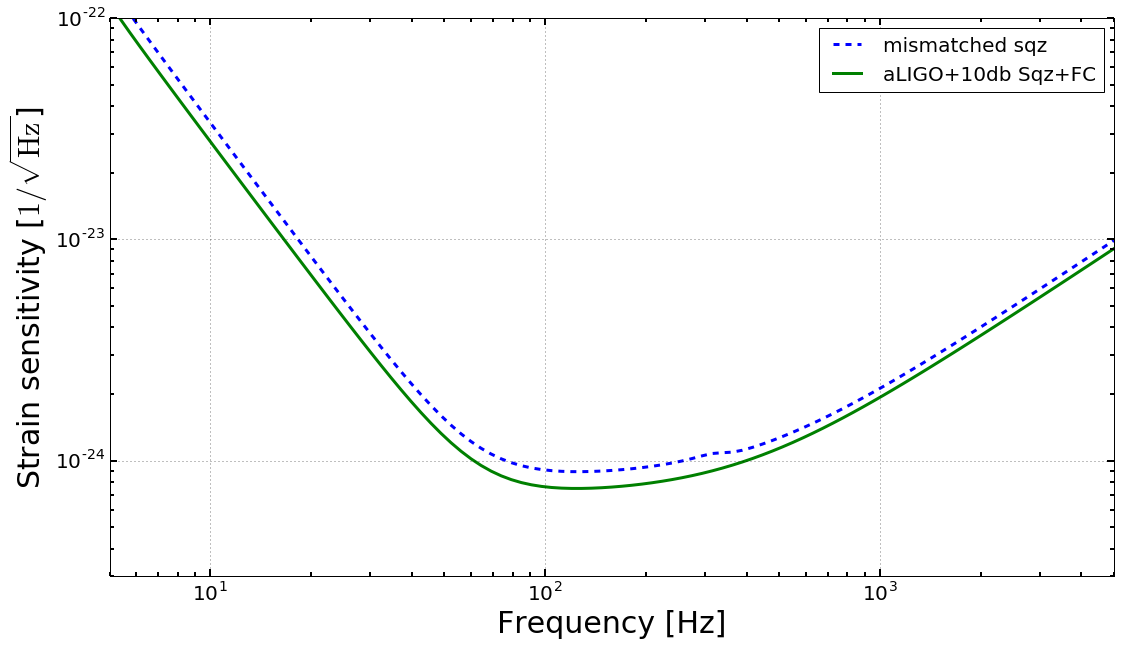

In [13]:
pl.figure(figsize=(18, 10), dpi=80)
pl.subplot(111)

pl.loglog(out_perfect_mm.x, out_mismatch_sqz['NSR_with_RP'],'--',linewidth=3, label='mismatched sqz')
pl.loglog(out_perfect_mm.x, out_perfect_mm['NSR_with_RP'],linewidth=3, label='aLIGO+10db Sqz+FC')

pl.xlim(out_perfect_mm.x.min(),out_perfect_mm.x.max())
pl.ylim(3e-25,1e-22)

pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Strain sensitivity [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=30)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)
pl.legend(fontsize=20)

pl.show()